## Dataset Selection

Select a dataset identically to the way you selected for lab one or lab three (table data or image data). You are not required to use the same dataset that you used in the past, but you are encouraged. You must identify a classification task from the dataset that contains three or more classes to predict. That is, it cannot be a binary classification; it must be multi-class prediction. 

## Grading Rubric

### Preparation (15 points total)
[5 points] (mostly the same processes as from lab four) Explain the task and what business-case or use-case it is designed to solve (or designed to investigate). Detail exactly what the task is and what parties would be interested in the results. How well would your prediction algorithm need to perform to be considered useful by interested parties?

[10 points] (mostly the same processes as from lab one) Define and prepare your class variables. Use proper variable representations (int, float, one-hot, etc.). Use pre-processing methods (as needed) for dimensionality reduction, scaling, etc. Remove variables that are not needed/useful for the analysis. Describe the final dataset that is used for classification/regression (include a description of any newly formed variables you created).

### Evaluation (30 points total)
[15 points] Choose and explain what metric(s) you will use to evaluate your algorithm’s generalization performance. You should give a detailed argument for why this (these) metric(s) are appropriate on your data. That is, why is the metric appropriate for the task (e.g., in terms of the business case for the task). Please note: rarely is accuracy the best evaluation metric to use. Think deeply about an appropriate measure of performance.

[15 points] Choose the method you will use for dividing your data into training and testing (i.e., are you using Stratified 10-fold cross validation? Why?). Explain why your chosen method is appropriate or use more than one method as appropriate. For example, if you are using time series data then you should be using continuous training and testing sets across time. Convince me that your cross validation method is a realistic mirroring of how an algorithm would be used in practice. 

Important: You should use your chosen evaluation criteria and chosen method for dividing train/test data throughout the report. For example, arguing that f-score is the best evaluation method, but then using accuracy in a grid search will be regarded as a conceptual error and graded accordingly. 
### Modeling (45 points total)
[20 points] Create a custom implementation of the multi-layer perceptron. Start with the implementation given to you in the course. Update the MLP class to:
When instantiated, use a selectable nonlinearity function for the first layer: either sigmoid or linear 
Use a selectable cost function when instantiated: either quadratic or cross entropy

[15 points] Tune the hyper-parameters of your MLP model (at least two hyper-parameters). While tuning hyper-parameters, analyze the results using your chosen metric(s) of evaluation. Visualize the evaluation metric(s) versus the hyper-parameters. Conclude what combination of parameters are best.

[10 points] Compare the performance of your MLP training procedure to scikit-learn. Which implementation is better in terms of generalization performance, computation time, and memory used while training?
Exceptional Work (10 points total)
You have free reign to provide additional analyses.
One idea: Add support for more than one hidden layer or a different nonlinear activation (i.e., softmax, tanh). Please note that different activation functions might require different weight initializations to work well. 

In [3]:
import pandas as pd
import numpy as np
import os
from scipy.misc import imread
import matplotlib.image as mpimg
import matplotlib.pyplot as plt
import random
import warnings
import seaborn as sns

%matplotlib inline
plt.style.use('ggplot')

In [4]:
directory = os.path.expanduser('../../train/')
images = []
files = []

# loop over directories: 
for i in range(1, 50001):
    name = str(i) + '.png'
    file = os.path.join(directory, name)
    images.append(mpimg.imread(file))

In [6]:
# Read in label
df = pd.read_csv('../../trainLabels.csv') # read in the csv file
labels = df.label.values

## Preparation 

In [12]:
# convert to luminance, thanks http://stackoverflow.com/questions/12201577/how-can-i-convert-an-rgb-image-into-grayscale-in-python

def rgb2gray(rgb):
    return np.dot(rgb[...,:3], [0.299, 0.587, 0.114])

for i in range(0, len(images)):
    images[i] = rgb2gray(images[i])

In [13]:
# a helper plotting function
def plot_gallery(images, titles, h, w, n_row=3, n_col=6):
    """Helper function to plot a gallery of portraits"""
    plt.figure(figsize=(1.7 * n_col, 2.3 * n_row))
    plt.subplots_adjust(bottom=0, left=.01, right=.99, top=.90, hspace=.35)
    for i in range(n_row * n_col):
        plt.subplot(n_row, n_col, i + 1)
        plt.imshow(images[i].reshape((h, w)), cmap=plt.cm.gray)
        plt.title(titles[i], size=12)
        plt.xticks(())
        plt.yticks(())

In [23]:
def reconstruct_image(trans_obj,org_features):
    low_rep = trans_obj.transform(org_features)
    rec_image = trans_obj.inverse_transform(low_rep)
    return low_rep, rec_image

In [19]:
def plot_explained_variance(pca):
    import plotly
    from plotly.graph_objs import Scatter, Marker, Layout, XAxis, YAxis, Bar, Line
    plotly.offline.init_notebook_mode() # run at the start of every notebook
    
    explained_var = pca.explained_variance_ratio_
    cum_var_exp = np.cumsum(explained_var)
    
    plotly.offline.iplot({
        "data": [Bar(y=explained_var, name='individual explained variance'),
                 Scatter(y=cum_var_exp, name='cumulative explained variance')
            ],
        "layout": Layout(xaxis=XAxis(title='Principal components'), yaxis=YAxis(title='Explained variance ratio'))
    })

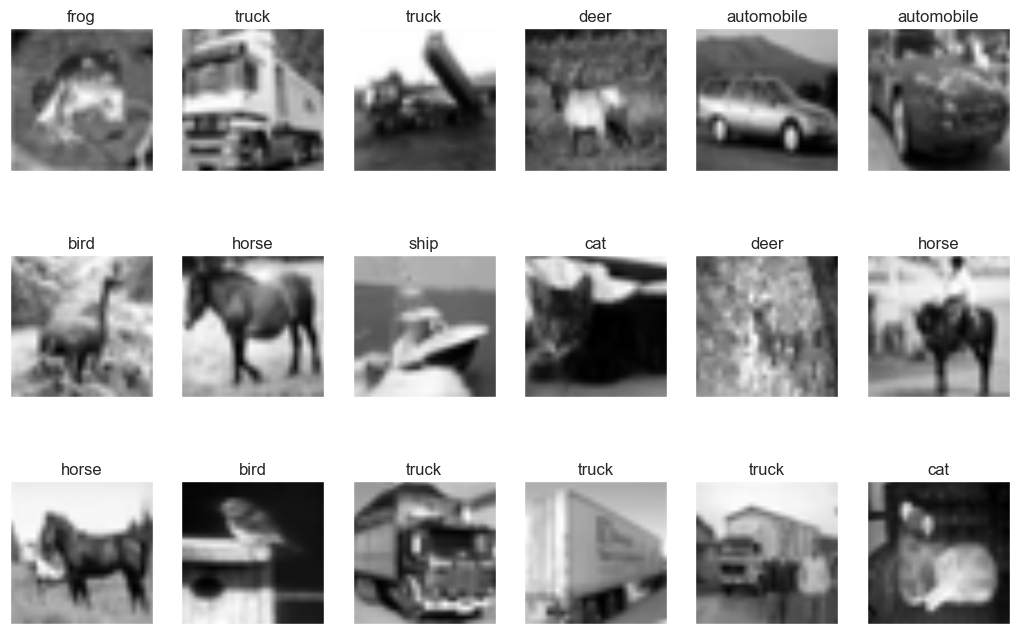

In [14]:
plot_gallery(images, labels, 32, 32) # defaults to showing a 3 by 6 subset of the faces

In [15]:
# Linearization
img_concat = []
for image in images: 
    img_concat.append(np.concatenate(image))

In [17]:
X = np.array(img_concat) 
names = labels

n_samples, n_features = X.shape
h, w = 32, 32
n_classes = len(names)

print("n_samples: {}".format(n_samples))
print("n_features: {}".format(n_features))
print("n_classes: {}".format(n_classes))
print("Original Image Sizes {}by{}".format(h,w))
print (125*94) # the size of the images are the size of the feature vectors

n_samples: 50000
n_features: 1024
n_classes: 50000
Original Image Sizes 32by32
11750


In [21]:
from sklearn.decomposition import PCA

n_components = 150
print ("Extracting the top %d eigenobjects from %d objects" % (
    n_components, X.shape[0]))

pca = PCA(n_components=n_components)
%time pca.fit(X)
eigenfaces = pca.components_.reshape((n_components, h, w))

Extracting the top 150 eigenobjects from 50000 objects
CPU times: user 17.8 s, sys: 2.13 s, total: 19.9 s
Wall time: 12.2 s


/Users/danh/anaconda/envs/machinelearning/lib/python3.5/site-packages/sklearn/utils/validation.py:395: DeprecationWarning:

Passing 1d arrays as data is deprecated in 0.17 and will raise ValueError in 0.19. Reshape your data either using X.reshape(-1, 1) if your data has a single feature or X.reshape(1, -1) if it contains a single sample.



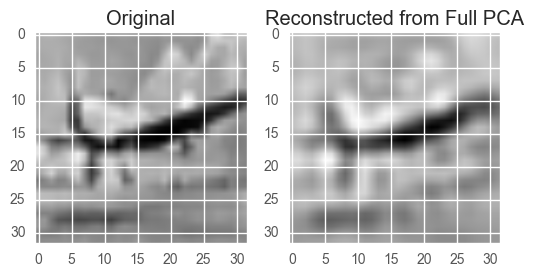

In [28]:
idx_to_reconstruct = 10020  
low_dimensional_representation, reconstructed_image = reconstruct_image(pca,X[idx_to_reconstruct])

plt.subplot(1,2,1)
plt.imshow(X[idx_to_reconstruct].reshape((h, w)), cmap=plt.cm.gray)
plt.title('Original')
plt.subplot(1,2,2)
plt.imshow(reconstructed_image.reshape((h, w)), cmap=plt.cm.gray)
plt.title('Reconstructed from Full PCA')